# Week 3 - Neural Networks

In this lecture we cover neural networks and continue our AWS discussion.

**Table of Contents**

-   [Data Preparation](#data-preparation)
    -   [Brazilian Coins](#coins)
-   [Neural Networks](#nn)
    -   [Score Function](#score)
    -   [Loss](#loss)
        -   [Hinge](#hinge)
        -   [Cross Entropy](#cross-entropy)
        -   [Squared Error](#se)
        -   [Regularization](#regularization)
    -   [Optimization](#optimization)
        -   [Linear Regression with Neural Network](#linear-nn)
    -   [Activation Function](#activation)
    -   [Example](#example)
        -   [Brazilian Coins (Regression)](#bc-regression)
        -   [Brazilian Coins (Classification)](#bc-classification)
-   [AWS CloudFormation](#aws-cloudformation)
    -   [Instance Software Configuration](#config)
        -   [UserData Property](#user-data)


<a id='data-preparation'></a>
## Data Preparation

In this part of the lecture, we'll go over some data preparation exercises involving images. In particular, we will be using images of Brazilian Coins. More information about the image collection can be found in [MONEDA, L. (2016) Brazilian Coins Dataset](http://lgmoneda.github.io/), and the associated Kaggle [competition](https://www.kaggle.com/lgmoneda/br-coins).

<a id='coins'></a>
### Brazilian Coins

Download and unzip the **regression_dataset.tar.gz.zip** file in the **Resources -> Week 3** folder in the CLE. 

This dataset contains about 6000 images of Brazilian Coins. Let's get a listing of all of the image files.

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

coin_files = [f for f in os.listdir("regression") if os.path.isfile(os.path.join("regression", f))]
coin_files[:10]

['100_1477154436.jpg',
 '100_1477154442.jpg',
 '100_1477154448.jpg',
 '100_1477154454.jpg',
 '100_1477154460.jpg',
 '100_1477154466.jpg',
 '100_1477154472.jpg',
 '100_1477154478.jpg',
 '100_1477154484.jpg',
 '100_1477154490.jpg']

The image filenames are formatted such that the number before the '\_' character indicates the total value of coins depicted in the image. This is our groud-truth label.

In [64]:
coin_values = [int(f[0:f.find("_")]) for f in coin_files] 
coin_values[:10]

[120, 50, 85, 10, 25, 50, 10, 10, 50, 5]

In [65]:
set(coin_values)

{5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 170,
 175}

[Keras](https://keras.io/) is a popular deep learning project, which has number of image preprocessing utilities.

In [9]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Let's take a look a an image from the dataset.

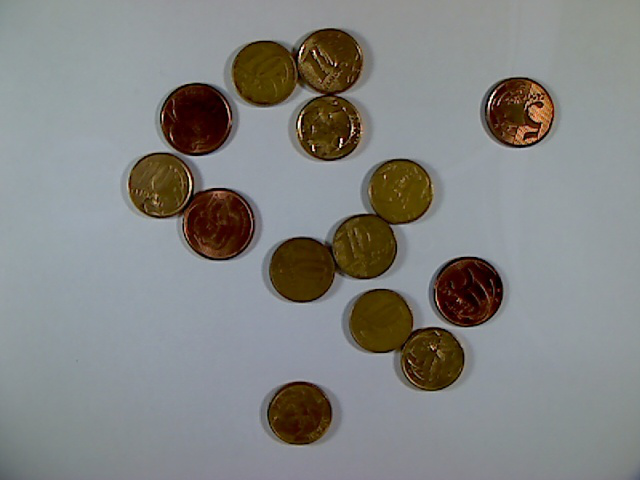

In [67]:
img = load_img(os.path.join("regression", coin_files[0]))
img

In [68]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [69]:
img.size

(640, 480)

A number of methods are available to operation on [PIL Image](https://pillow.readthedocs.io/en/latest/reference/Image.html)s. For example, we can reduce the dimensions and keep the same aspect ratio with the `thumbnail` function. Note that is function modifies the image object in-place.

In [70]:
img.thumbnail((160,120))

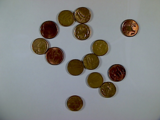

In [71]:
img

We can also flip the image.

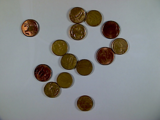

In [72]:
from PIL import Image
img_t = img.transpose(Image.FLIP_LEFT_RIGHT)
img_t

Or rotate it.

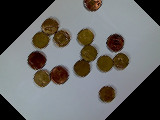

In [73]:
img_r = img.rotate(45)
img_r

We can also convert a PIL Image to a numpy array, which is a format condusive to modeling. Let's do this for all of the images in our dataset.

In [74]:
img_to_array(img).shape

(120, 160, 3)

In [75]:
import numpy as np

coins = np.ndarray(shape=(len(coin_files), 120*160*3), dtype=np.float32)

i = 0
for f in coin_files:
    img = load_img("regression/" + f)
    img.thumbnail((160, 120))
    x = img_to_array(img)  
    x = x.reshape(120*160*3)
    coins[i] = x
    i += 1

In [76]:
coins.shape

(6028, 57600)

Let's split our dataset into training and testing sets.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(coins, coin_values, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape)
print(len(Y_train), len(Y_test))

(2753, 57600) (306, 57600)
2753 306


It's common to *center* image data. Here, we subtract the column mean, over the **training** data, from each column entry in the training and test sets.

In [78]:
train_mean = np.mean(X_train, axis = 0)
train_mean.shape

(57600,)

In [79]:
X_train_cen = X_train - train_mean
X_test_cen  = X_test  - train_mean

If the features are not on the same scale, then it's also common to scale the features by the standard deviation. Centering and scaling in this manner is known as *standardization*.

In [80]:
train_sd = np.std(X_train, axis = 0)
train_sd.shape

(57600,)

In [81]:
X_train_std = (X_train - train_mean) / train_sd
X_test_std  = (X_test  - train_mean) / train_sd

The same workflow can be achieved in R. See *week3_R.Rmd* for the code.

<a id='nn'></a>
## Neural Networks

We'll introduce neural network concepts through a linear classification problem. In particular we'll attempt to classify an image of a Brazilian coin as belonging to one 5 denominations. A good reference for the content of this lecture can be found in these [notes](http://cs231n.github.io/) by [Andrej Karpathy](https://cs.stanford.edu/people/karpathy/).

<a id='score'></a>
### Score Function

The first part of the neural network we'll introduce is the *score function*. This function maps an input observation to an output, or response value. For image classification, it will map an image, $x_i \in R^D $, with $D$ pixels, into a vector of $K$ class scores. That is, $f : R^D \mapsto R^K$ 

A linear classifier could be implemented with $f(x_i,W,b) = Wx_i + b$

Here, $W$ and $b$ are the model *parameters*, where $W$ is a matrix of size \[K x D\] and $b$ is a vector of size \[K x 1\]. So, an image, $x_i$, which is represented by a column vector of size \[D x 1\], is transformed into a vector of $K$ class scores by our function.

$W$ and $b$ are often referred to as the *weights* and *biases* of the model. 

Sometimes the weights and biases are combined into a single matrix. Our linear classifier takes the form $f(x_i,W) = Wx_i$, but now $W$ is of size \[K x (D+1)\], and the (D+1)th entry in $x_i$ is set to the constant value of 1. Note that both forms are functionally equivalent, but some prefer the simplified representation.

We can represent the score function graphically, with nodes and edges. I used [this](http://alexlenail.me/NN-SVG/index.html) tool to draw my network.

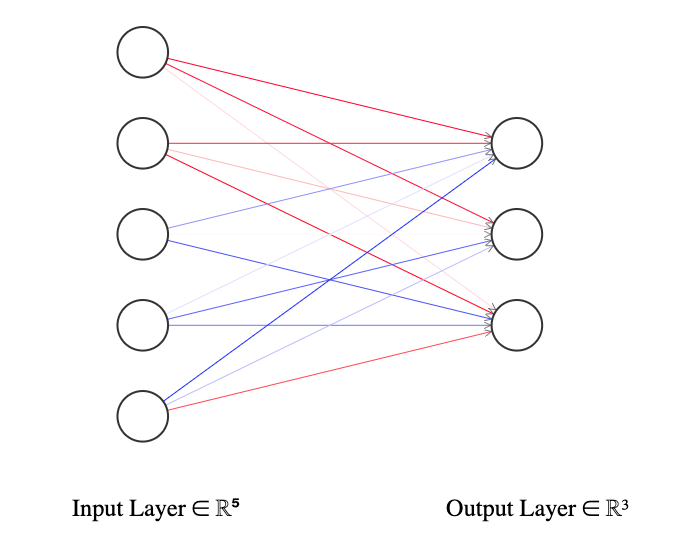

In [24]:
from IPython.display import Image
Image(filename='nn0.png') 

Continuing with a linear classification example, the input $x_i$ is a vector of size \[5 x 1\] (4 pixels and the bias constant 1, for example). The response is a vector of size \[3 x 1\]. $W$ is a matrix of size \[3 x 5\].

Each directed edge in the graph has an individual weight from $W$ associated with it. 

Functionally, we can add a *hidden layer* with $W_2W_1x_i$. 

<a id='loss'></a>
### Loss Function

Given the input data, there are a number of ways that we can quantify the goodness of the parameters. We can score each observation and compare it to the ground truth to quantify the *loss*. We'll introduce a number of loss methods, including the hinge loss, cross-entropy loss, and squared error.

In the bigger scheme of things, once we decide how to quantify the loss over the input data and parameters, we can optimize it.

<a id='hinge'></a>
#### Hinge

For multi-class classification problems, the hinge loss for observation $i$ is defined as $L_i = \sum\limits_{j \ne y_i}max(0, w_{j}^{T}x_i − w_{y_i}^{T}x_i + \Delta)$. In other words, the score for each incorrect class is compared to the score for the correct class, $y_i$. If the score for the correct class isn't larger than the score for the incorrect class by some margin $\Delta$, then a penalty is accumulated. Otherwise, 0 penalty is accumulated. $\Delta$ is a parameter that is often just set to 1.0 for reasons discussed below.

<a id='cross-entropy'></a>
#### Cross Entropy

For multi-class classification problems, the cross entropy loss for observation $i$ is defined as $L_i = -\log(\frac{e^{f_{y_i}}}{\sum\limits_j e^{f_j}})$, where $f_j$ is the score for class $j$. 

The function $f_j(z) = \frac{e^{z_j}}{\sum\limits_k e^{z_k}}$ is called the *softmax function* and it takes a vector of real-valued entries, $z$, and transforms it into a vector of entries between 0 and 1 summing to 1. 

<a id='se'></a>
#### Squared Error

For regression problems, the squared error for observation $i$ is simply the square of the actual value minus the predicted value, or score. $L_i = (y_i - \hat{y}_i)^2$ 

<a id='regularization'></a>
#### Regularization

Penalizing large weights, in favor or smaller, more distributed weights, can reduce the effect any single input dimension has on the output. This weight *regularization* is often used to improve model generalization and reduce overfitting. It is accomplished by adding a weights penalty to the loss function. This often takes the form of the *L2 norm*, $R(W) = \sum\limits_k\sum\limits_lW_{k,l}^2$, which is simply an element-wise summing of the squared weight value.

The loss function in its full form is defined as $L = \frac{1}{N} \sum\limits_iL_i + \lambda R(W)$, where $\lambda$ is a regularization parameter that should be tuned via cross-validation, for example. When using the hinge loss, as mentioned above, $\Delta$ is usually just set to 1.0, and $\lambda$ is used to control the tradeoff between the data loss and regularization loss.

Which loss function should you use? 

<a id='optimization'></a>
### Optimization

We're finally ready to optimize the loss function, or *learn* the model weights. 

The loss function can have many dimensions, so it is probably not possible to visualize it. However, we can gain some intuition into the optimization process by visualizing an example of a 2-d loss function.

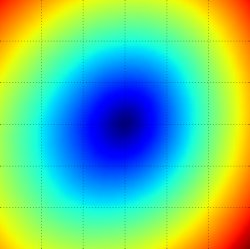

In [15]:
from IPython.display import Image
Image(filename='lf.jpg') 

In this case, blue means low loss, and red means high loss, and the objective is to find the dimensions that minimize the loss. Given an initial, perhaps random, starting point in the loss function space, one approach to finding the minimum is to first compute the *gradient* at the starting point. Then, take a *step* in the opposite direction of the gradient. This process is called *gradient descent*, and is continued until some stopping criteria is satisfied.

A pseudo-code implementation of gradient descent might be:

```python
# Source: http://cs231n.github.io/optimization-1/
# Vanilla Gradient Descent

while True:
  weights_grad = evaluate_gradient(loss_fun, data, weights)
  weights += - step_size * weights_grad # perform parameter update
```

There are a number of ways to implement the `evaluate_gradient` function. *Backpropagation*, which computes the gradient analytically using the chain rule, is an efficient method.

Often, the entire `data` is not used to evaluate the gradient for each iteration. Instead, the data is broken up into separate *batch*s of training data, and each iteration only considers a single batch. This is referred to as *mini-batching*. If the batches are good approximations of the full data, then faster convergence can be achieved. Terminology-wise, if the batch is of size 1, then this is referred to as *stochastic gradient descent*, or SGD, although people/packages often use SGD to mean mini-batch gradient descent. 

A *batch* should not be confused with an *epoch*. An epoch is achieved when all of the batches (i.e. all of the training data) have been used to update the weights. The batch size and the number of epochs are common input parameters to neural network algorithms.   

How big should the batch size be?

How many epochs should you choose? Alternatively, some neural network algorithms allow you to specify a stopping condition based on the stabilization of performance on a validation set. How do you define stabilization?

How big should the `step_size`, or *learning rate*, be?

<a id='activation'></a>
### Activation Function

Recall that our score function, up to this point has been linear (in the parameters). Our linear classifier took the form $f(x_i,W) = Wx_i$. We can add an arbitrary number of hidden layers, and maintain this linearity, $W_n...W_2W_1x_i$.

We can introduce non-linearity into the score function fairly easily. For example, the score function $W_2\max(0,W_1x_i)$, where $x_i$ is some $D$-dimensional column vector, $W_1$ a \[$L_1$ x $D$\] matrix, and $W_2$ a \[$L_2$ x $L_1$\] matrix, is non-linear due to the $\max(0,W_1x_i)$ function, which is applied element-wise to the resulting \[$L_1$ x $1$\] matrix. Here, the $\max(0,Wx_i)$ function is called the *activation function*. 

Why should we use an activation function? It has been [shown](http://www.dartmouth.edu/~gvc/Cybenko_MCSS.pdf) that neural networks can model **ANY** continuous function with at least one hidden layer and an activation function, such as the sigmoid ([another explanation](http://neuralnetworksanddeeplearning.com/chap4.html)). 

There are a number of popular activation functions, including sigmoid, tanh, relu, leaky relu, and maxout. Which one should you use? Take a look at the section [Commonly used activation functions](http://cs231n.github.io/neural-networks-1/).

<a id='example'></a>
### Example

We're going to solve the Brazilian coins regression and classification problems with a deep-learning python package called [keras](https://keras.io/).

<a id='bc-regression'></a>
#### Brazilian Coins (Regression)

In [2]:
from keras.models import Sequential

model1 = Sequential()
model2 = Sequential()

Using TensorFlow backend.
W0731 10:04:50.309326 17224 deprecation_wrapper.py:119] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
from keras.layers import Dense

model1.add(Dense(units=64, activation='tanh', kernel_initializer='random_normal', input_dim=57600))
model1.add(Dense(units=64, activation='tanh', kernel_initializer='random_normal'))
model1.add(Dense(units=64, activation='tanh', kernel_initializer='random_normal'))
model1.add(Dense(units=1                    , kernel_initializer='random_normal'))

model2.add(Dense(units=64, activation='relu', kernel_initializer='random_normal', input_dim=57600))
model2.add(Dense(units=64, activation='relu', kernel_initializer='random_normal'))
model2.add(Dense(units=64, activation='relu', kernel_initializer='random_normal'))
model2.add(Dense(units=64, activation='relu', kernel_initializer='random_normal'))
model2.add(Dense(units=1                    , kernel_initializer='random_normal'))

W0731 10:04:50.336262 17224 deprecation_wrapper.py:119] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 10:04:50.345282 17224 deprecation_wrapper.py:119] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [4]:
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3686464   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 3,694,849
Trainable params: 3,694,849
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                3686464   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 3,699,009
Trainable params: 3,699,009
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
from keras import optimizers

sgd1 = optimizers.SGD(lr=0.0001)
sgd2 = optimizers.SGD(lr=0.000001)

model1.compile(loss='mse', optimizer=sgd1)
model2.compile(loss='mse', optimizer=sgd2)

W0731 10:04:50.511513 17224 deprecation_wrapper.py:119] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [7]:
model1.fit(X_train, Y_train, epochs=10, batch_size=32)

NameError: name 'X_train' is not defined

In [30]:
loss_and_metrics = model1.evaluate(X_test, Y_test)
loss_and_metrics

603/603 [==============================] - 1s 1ms/step


1944.9343921667703

In [31]:
model1.predict(X_test)

array([[63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.05883 ],
       [63.063526],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.059456],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],
       [63.078934],


In [34]:
sum(Y_train)/len(Y_train)

63.10967741935484

What happens if we center the data?

In [35]:
model1.fit(X_train_cen, Y_train, epochs=10, batch_size=32)

Epoch 1/10
5425/5425 [==============================] - 9s 2ms/step - loss: 1937.0667
Epoch 2/10
5425/5425 [==============================] - 4s 823us/step - loss: 1493.1838
Epoch 3/10
5425/5425 [==============================] - 4s 787us/step - loss: 1459.0866
Epoch 4/10
5425/5425 [==============================] - 4s 780us/step - loss: 1388.8259
Epoch 5/10
5425/5425 [==============================] - 5s 841us/step - loss: 1374.0500
Epoch 6/10
5425/5425 [==============================] - 4s 779us/step - loss: 1325.8677
Epoch 7/10
5425/5425 [==============================] - 4s 809us/step - loss: 1297.3907
Epoch 8/10
5425/5425 [==============================] - 5s 863us/step - loss: 1249.0462
Epoch 9/10
5425/5425 [==============================] - 5s 842us/step - loss: 1221.1756
Epoch 10/10
5425/5425 [==============================] - 5s 877us/step - loss: 1198.2093


In [36]:
loss_and_metrics = model1.evaluate(X_test_cen, Y_test)
loss_and_metrics

603/603 [==============================] - 0s 681us/step


1170.8694477239453

In [37]:
model1.predict(X_test)

array([[30.138947],
       [42.134567],
       [56.52154 ],
       [56.52154 ],
       [30.138947],
       [42.134567],
       [30.138948],
       [41.80576 ],
       [44.072926],
       [43.98095 ],
       [42.134567],
       [54.197163],
       [56.52154 ],
       [39.099674],
       [54.197166],
       [45.612103],
       [45.03531 ],
       [56.52154 ],
       [30.138947],
       [45.612103],
       [30.138947],
       [39.099674],
       [30.138948],
       [30.138948],
       [45.612103],
       [30.138947],
       [45.612103],
       [42.134567],
       [32.732704],
       [56.52154 ],
       [44.82417 ],
       [45.612103],
       [30.138947],
       [56.52154 ],
       [44.824165],
       [32.732704],
       [45.612103],
       [45.612103],
       [45.612103],
       [42.134567],
       [42.134567],
       [45.612103],
       [56.52154 ],
       [30.138947],
       [45.612103],
       [30.138947],
       [30.138948],
       [45.612103],
       [45.612103],
       [45.612103],


In [44]:
model2.fit(X_train_cen, Y_train, epochs=40, batch_size=512)

Epoch 1/40
5425/5425 [==============================] - 1s 257us/step - loss: 1148.1579
Epoch 2/40
5425/5425 [==============================] - 1s 245us/step - loss: 1144.1684
Epoch 3/40
5425/5425 [==============================] - 1s 224us/step - loss: 1139.5102
Epoch 4/40
5425/5425 [==============================] - 1s 245us/step - loss: 1135.4495
Epoch 5/40
5425/5425 [==============================] - 1s 245us/step - loss: 1131.0980
Epoch 6/40
5425/5425 [==============================] - 2s 283us/step - loss: 1126.9925
Epoch 7/40
5425/5425 [==============================] - 1s 218us/step - loss: 1122.9664
Epoch 8/40
5425/5425 [==============================] - 1s 233us/step - loss: 1119.4234
Epoch 9/40
5425/5425 [==============================] - 1s 236us/step - loss: 1115.2811
Epoch 10/40
5425/5425 [==============================] - 1s 220us/step - loss: 1111.5794
Epoch 11/40
5425/5425 [==============================] - 1s 240us/step - loss: 1107.6588
Epoch 12/40
5425/5425 [=======

In [45]:
loss_and_metrics = model2.evaluate(X_test_cen, Y_test)
loss_and_metrics

603/603 [==============================] - 0s 144us/step


1038.1455282587713

In [46]:
[(p[0], a) for p, a in zip(model2.predict(X_test_cen), Y_test)]

[(72.923386, 125),
 (44.877476, 100),
 (102.260315, 115),
 (61.48796, 10),
 (35.06995, 50),
 (37.320568, 50),
 (29.479757, 10),
 (56.714527, 50),
 (95.666565, 140),
 (130.82349, 100),
 (57.38338, 25),
 (59.29701, 10),
 (75.99691, 80),
 (42.813602, 100),
 (128.69893, 110),
 (33.1461, 5),
 (90.42983, 40),
 (98.7239, 150),
 (44.555542, 10),
 (45.537785, 5),
 (30.848257, 10),
 (35.25942, 10),
 (46.245045, 5),
 (39.548164, 25),
 (59.226345, 60),
 (35.48367, 25),
 (105.64551, 70),
 (56.903324, 100),
 (40.662266, 5),
 (84.666695, 110),
 (134.98564, 120),
 (66.39997, 95),
 (41.69565, 50),
 (81.35217, 85),
 (81.405075, 135),
 (49.01514, 55),
 (45.87612, 25),
 (111.075165, 90),
 (72.13447, 60),
 (34.866985, 50),
 (37.407993, 5),
 (45.080692, 25),
 (129.09346, 75),
 (30.001614, 5),
 (36.556145, 5),
 (34.711887, 50),
 (51.37252, 50),
 (68.220505, 45),
 (46.32839, 50),
 (108.299736, 85),
 (45.64898, 75),
 (37.678616, 5),
 (48.60605, 50),
 (32.553757, 5),
 (36.68063, 50),
 (39.67068, 50),
 (35.81779

Does standardizing the data lead to any improvements?

<a id='bc-classification'></a>
#### Brazilian Coins (Classification)

Let's see if we can build a good model for classifiying single-coin images.

In [10]:
coin_files = [f for f in os.listdir("classification") if os.path.isfile(os.path.join("classification", f))]
coin_files[:10]

['100_1477154436.jpg',
 '100_1477154442.jpg',
 '100_1477154448.jpg',
 '100_1477154454.jpg',
 '100_1477154460.jpg',
 '100_1477154466.jpg',
 '100_1477154472.jpg',
 '100_1477154478.jpg',
 '100_1477154484.jpg',
 '100_1477154490.jpg']

In [11]:
coin_values = [int(f[0:f.find("_")]) for f in coin_files] 
set(coin_values)

{5, 10, 25, 50, 100}

In [12]:
import numpy as np
coins = np.ndarray(shape=(len(coin_files), 120*160*3), dtype=np.float32)
i = 0
for f in coin_files:
    img = load_img("classification/" + f)
    img = img.resize((160, 120))
    x = img_to_array(img)  
    x = x.reshape(120*160*3)
    coins[i] = x
    i += 1

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(coins, coin_values, test_size=0.1)

print(X_train.shape, X_test.shape)
print(len(Y_train), len(Y_test))

(2753, 57600) (306, 57600)
2753 306


In [17]:
train_mean = np.mean(X_train, axis = 0)
train_mean.shape

(57600,)

In [18]:
X_train_cen = X_train - train_mean
X_test_cen  = X_test  - train_mean

In [19]:
model = Sequential()

In [20]:
from keras import regularizers
reg = regularizers.l2(0.01)

model.add(Dense(units=64, activation='relu'   , kernel_initializer='random_normal', kernel_regularizer=reg, input_dim=57600))
model.add(Dense(units=128,activation='relu'   , kernel_initializer='random_normal', kernel_regularizer=reg))
model.add(Dense(units=32, activation='relu'   , kernel_initializer='random_normal', kernel_regularizer=reg))
model.add(Dense(units=64, activation='relu'   , kernel_initializer='random_normal', kernel_regularizer=reg))
model.add(Dense(units=5 , activation='softmax', kernel_initializer='random_normal', kernel_regularizer=reg))

In [21]:
sgd = optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=sgd,  metrics=['accuracy'])

W0731 10:07:21.932820 17224 deprecation_wrapper.py:119] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [22]:
print(Y_train[:10])
print(len(Y_train))
y_map = {5:0, 10:1, 25:2, 50:3, 100:4}
Y_train_mapped = [y_map[v] for v in Y_train]
print(Y_train_mapped[:10])
print(len(Y_train_mapped))

Y_test_mapped = [y_map[v] for v in Y_test]

[5, 10, 25, 50, 50, 50, 10, 50, 100, 100]
2753
[0, 1, 2, 3, 3, 3, 1, 3, 4, 4]
2753


In [25]:
from keras.utils import to_categorical
Y_train_cat = to_categorical(Y_train_mapped)
Y_test_cat = to_categorical(Y_test_mapped)
print(Y_test_cat[:10])
type(Y_test_cat)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


numpy.ndarray

In [26]:
history = model.fit(X_train_cen, Y_train_cat, validation_split=0.20, epochs=50, batch_size=64, verbose=1)

W0731 10:12:16.170562 17224 deprecation.py:323] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0731 10:12:16.213439 17224 deprecation_wrapper.py:119] From C:\Users\melissa.wickers\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 2202 samples, validate on 551 samples
Epoch 1/50
2202/2202 [==============================] - 3s 2ms/step - loss: 94.1779 - acc: 0.2193 - val_loss: 94.0214 - val_acc: 0.1924
Epoch 2/50
2202/2202 [==============================] - 3s 1ms/step - loss: 93.9482 - acc: 0.2307 - val_loss: 93.8549 - val_acc: 0.2359
Epoch 3/50
2202/2202 [==============================] - 3s 1ms/step - loss: 93.7821 - acc: 0.2398 - val_loss: 93.7078 - val_acc: 0.2450
Epoch 4/50
2202/2202 [==============================] - 3s 1ms/step - loss: 93.6285 - acc: 0.2566 - val_loss: 93.5725 - val_acc: 0.2305
Epoch 5/50
2202/2202 [==============================] - 3s 1ms/step - loss: 93.4810 - acc: 0.2743 - val_loss: 93.4313 - val_acc: 0.2450
Epoch 6/50
2202/2202 [==============================] - 3s 1ms/step - loss: 93.3340 - acc: 0.2852 - val_loss: 93.2891 - val_acc: 0.2432
Epoch 7/50
2202/2202 [==============================] - 3s 1ms/step - loss: 93.1890 - acc: 0.2984 - val_loss: 93.1559 - val_acc: 0.2414
E

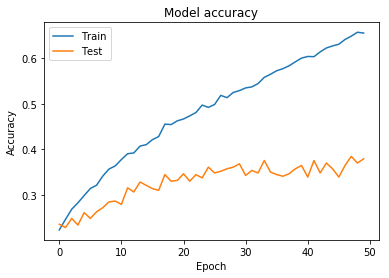

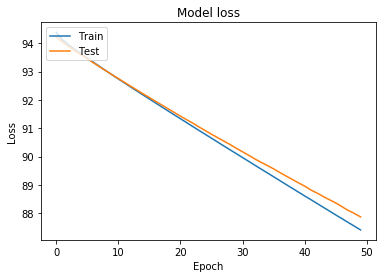

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [60]:
loss_and_metrics = model.evaluate(X_test_cen, Y_test_cat)
loss_and_metrics

306/306 [==============================] - 0s 394us/step


[87.91728828779233, 0.3954248366013072]

In [61]:
classes = model.predict(X_test_cen)
classes

array([[1.30223902e-02, 2.65519539e-05, 1.37342839e-03, 1.35143161e-01,
        8.50434422e-01],
       [3.41497958e-01, 6.08124509e-02, 1.30200490e-01, 6.03340119e-02,
        4.07155067e-01],
       [1.47471204e-01, 4.41986788e-03, 1.84837714e-01, 2.07703277e-01,
        4.55567956e-01],
       ...,
       [3.41518104e-01, 3.78113449e-01, 2.41842464e-01, 3.49862198e-03,
        3.50274332e-02],
       [2.59149045e-01, 1.00622594e-01, 2.99917221e-01, 9.87700298e-02,
        2.41541103e-01],
       [2.68352509e-01, 3.69810641e-01, 1.52049527e-01, 1.48554921e-01,
        6.12323657e-02]], dtype=float32)

In [62]:
reverse_y_map = {0:5, 1:10, 2:25, 3:50, 4:100}
pred_act = [(reverse_y_map[np.argmax(p)], a) for p, a in zip(model.predict(X_test_cen), Y_test)]
sum([p==a for p,a in pred_act]) / float(len(pred_act))

0.3954248366013072

<a id='aws-cloudformation'></a>
## AWS CloudFormation

<a id='config'></a>
### Instance Software Configuration

Many EC2 instance configuration options are available to [AWS::EC2::Instance](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-properties-ec2-instance.html#cfn-ec2-instance-userdata) resources, including *Volumes*, *SecurityGroups*, and *NetworkConfigurations*. However, most of these configuration options are hardware or network-related. 

We'd like to codify our software configurations, for the same reasons we like to codify our network and hardware configurations. In a disaster recovery scenario, we don't want to be scrambling to manually install software. In terms of organizational communication, if software configurations are codified, they can be shared and controlled much easier.

<a id='user-data'></a>
#### UserData Property

The AWS::EC2::Instance resources type has a [UserData](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-properties-ec2-instance.html#cfn-ec2-instance-userdata) property, which allows use to make user data available to an EC2 instance, including a *bash* script.

[Shell scripts specified by the UserData property](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/user-data.html#user-data-shell-scripts) are executed during the boot phase when an instance is first launched. They will not be executed upon reboot.

Shell scripts should start with `#!/path/to/interpreter` (i.e. `#!/bin/bash`). The script is run as *root*. It's possible that users will require access to root-owned resources, so permissions should be updated accordingly.

The output of the shell script is stored in the file `/var/log/cloud-init-output.log`. This log is invaluable when you are trying to troubleshoot a *mis*-configuration. Sometimes the shell script can take awhile to run. In these cases you can ssh onto the machine and *tail* (`tail -f /var/log/cloud-init.log `) the logs and watch the configuration live.

The shell script, itself, is stored and executed from `/var/lib/cloud/instances/instance-id/`.

Let's examine the UserData property as specified in last week's lab.

```YAML
      UserData: 
        Fn::Base64: !Sub |
          #!/bin/bash
          # Resize root volume
          /sbin/resize2fs /dev/sda

          # Software pre-requisites
          apt-get update
          apt-get -y install python3-pip
          apt-get -y install python3 python-dev python3-dev build-essential libssl-dev libffi-dev libxml2-dev libxslt1-dev zlib1g-dev python-pip
          curl -sL https://deb.nodesource.com/setup_8.x -o nodesource_setup.sh
          bash nodesource_setup.sh
          apt-get -y install nodejs
          hash -r
          npm install -g configurable-http-proxy
          pip3 install jupyterhub
          pip3 install notebook==5.7.4

          # tornado v. 6 is broken
          pip3 uninstall tornado
          pip3 install tornado==5.1.1

          # global install of other python packages
          pip3 install pandas --target /usr/local/lib/python3.5/dist-packages/
          pip3 install xgboost --target /usr/local/lib/python3.5/dist-packages/
          pip3 uninstall matplotlib
          apt-get -y install python3-matplotlib
          pip3 install sklearn --target /usr/local/lib/python3.5/dist-packages/
          pip3 install hyperopt --target /usr/local/lib/python3.5/dist-packages/

          mkdir /srv/jupyterhub # for all security and runtime files
          mkdir /etc/jupyterhub # for all configuration files
          # /var/log for log files

          # Set up jupyter hub as a service
          echo "c.JupyterHub.base_url='/'" >> /etc/jupyterhub/jupyterhub_config.py
          printf 'After=syslog.target network.target\n\n[Service]\nUser=root\nExecStart=/usr/local/bin/jupyterhub -f /etc/jupyterhub/jupyterhub_config.py\n\n[Install]\nWantedBy=multi-user.target\n' >> /etc/systemd/system/jupyterhub.service
          systemctl enable jupyterhub.service
          systemctl daemon-reload
          systemctl restart jupyterhub.service

          # User setup
          users="eric.eckstrand blah.blah"
          for i in $users; do sudo useradd -m -d /home/$i -s /bin/bash $i; done
          for i in $users; do sudo usermod --password $(openssl passwd -1 $i) $i; done
```

It's helpful to have some (ubuntu) linux familiarity in order to understand this script. For this course, there is no expectation for you to learn linux shell scripting. However, I find that when creating a CloudFormation Stack, most of my time is spent in this section, configuring software tools, such as JupyterHub or RStudio. 

One approach that I find useful for developing the software configuration, is to boot your instance without any UserData specified, first. Next, configure the software manually and record the steps you took along the way. Once it's working, copy your recorded commands to your shell script. 

Of note, the script is run as root, so `sudo` is not necessary. 

The [!Sub](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/intrinsic-function-reference-sub.html) function simply substitutes any template parameters, resource logical IDs, or resource attributes with their actual values. In this example, no substitutions are made, so it's not necessary. 

The YAML [pipe](https://yaml.org/spec/1.2/spec.html#id2795688) operator, "|", allows us to write the script in a readable way (i.e. it's not necessary to explicity specify '\n' characters to end a line).

The [Fn::Base64]() just means to encode the script (string) using [base64](https://en.wikipedia.org/wiki/Base64) encoding, which is required by the EC2 instance.